In [ ]:
!pip install keras-tuner -q

# 1 Ajuste del learning rate y batch size
### Learning rate: principal hiperparámetro a ajustar en descenso por gradiente estocástico (SGD)
### Batch size: otro hiperparámetro a ajustar muy importante

In [ ]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; import keras_tuner
keras.utils.set_random_seed(23); input_dim = 784; num_classes = 10
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]

### MyHyperModel: tras pruebas informales, exploramos learning rate próximo a 0.0017 y batch size de 64, 128 o 256

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
 def build(self, hp):
  M = keras.Sequential()
  M.add(keras.Input(shape=(784,)))
  M.add(keras.layers.Dense(units=800, activation='relu'))
  M.add(keras.layers.Dense(10, activation='softmax'))
  learning_rate = hp.Float("lr", min_value=0.0015, max_value=0.0019)
  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
  return M
 def fit(self, hp, M, x, y, xy_val, **kwargs):
  bs = hp.Int("batch_size", 64, 256, step=2, sampling="log")
  early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-5)
  kwargs['callbacks'].append(early_cb)
  return M.fit(x, y, batch_size=bs, epochs=100, validation_data=xy_val, **kwargs)

### Experimento: solo hacemos 3 experimentos para facilitar computacionalmente su reproducción

In [ ]:
tuner = keras_tuner.BayesianOptimization(
 MyHyperModel(), objective="val_accuracy", max_trials=3,
 overwrite=True, directory="/tmp", project_name="MNIST")

In [ ]:
tuner.search(x_train, y_train, (x_val, y_val))

Trial 3 Complete [00h 00m 53s]
val_accuracy: 0.984499990940094

Best val_accuracy So Far: 0.9854999780654907
Total elapsed time: 00h 02m 30s


In [ ]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
lr: 0.0016787335100293622
batch_size: 256
Score: 0.9854999780654907


In [ ]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.07691
Precisión: 98.31%


### Experimento (cont.): iteraciones adicionales con train_val y evaluación en test


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(x_train_val, y_train_val, batch_size=256, epochs=10, validation_data=(x_test, y_test), verbose=0)
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')


Loss: 0.07699
Precisión: 98.49%


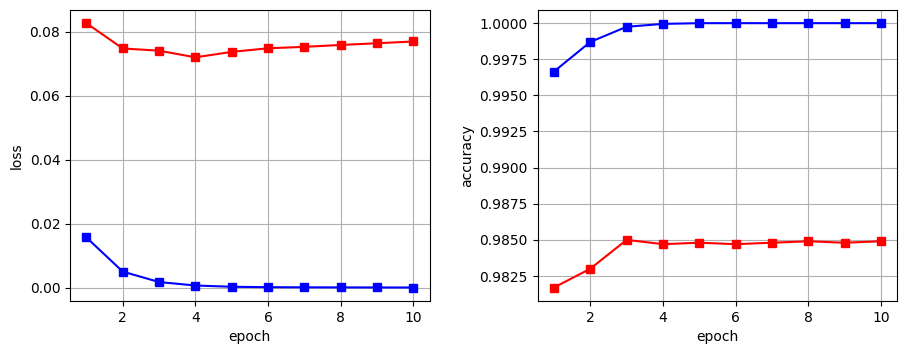

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');

# 2-Planificadores
###  Función para modificar el learning rate a medida que SGD avanza
